# Topic Trends - Pandemics

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

from brokenaxes import brokenaxes

ModuleNotFoundError: No module named 'brokenaxes'

### Data Ingestion

In [2]:
# upload the data
df = pd.read_csv('/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/abstracts_classification_big_data.csv')
df.reset_index(inplace=True, drop = True)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (15,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.shape

(39997, 42)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN,score,Big_data
0,14,14,90013,This multidisciplinary project draws upon soci...,career; Collaborations; Communities; Complex; ...,CDI-TYPE II: WHAT DRIVES THE DYNAMIC CREATION ...,NSF,NSF,NaN,0835614,9/15/2008,8/31/2012,"MCFARLAND, DANIEL","JURAFSKY, DANIEL; MANNING, CHRISTOPHER; POWELL...",14.0,009214214,STANFORD UNIVERSITY,STANFORD,CA,94305-6203,UNITED STATES,NaN,NaN,47.076,2008,1186174.0,NaN,1,1,1186174.0,1,multidisciplinary project draw sociology compu...,14,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
1,21,21,89990,Pruden 0547342 This research opens a new par...,Address; Anthrax disease; anthropogenesis; Ant...,CAREER: ANTIBIOTIC RESISTANCE GENES (ARG) AS E...,NSF,NSF,NaN,0852942,9/1/2008,1/31/2011,"PRUDEN, AMY J",NaN,9.0,003137015,VIRGINIA POLYTECHNIC INSTITUTE AND STATE UNIVE...,BLACKSBURG,VA,24060-0000,UNITED STATES,NaN,NaN,47.041,2008,197729.0,NaN,1,1,197729.0,1,pruden research open new paradigm view biomole...,21,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
2,28,28,89972,Eye tracking has become a widespread tool thro...,Affect; Attention; Attention Deficit Disorder;...,CDI-TYPE I: UNDERSTANDING REGULATION OF VISUAL...,NSF,NSF,NaN,0835767,10/1/2008,3/31/2012,"SCASSELLATI, BRIAN M","CHAWARSKA, KATARZYNA",3.0,043207562,YALE UNIVERSITY,NEW HAVEN,CT,06520-8337,UNITED STATES,NaN,NaN,47.075,2008,700000.0,NaN,1,1,700000.0,1,eye tracking widespread tool cognitive science...,28,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
3,39,39,89969,"The proposed workshop, to be held at the Banff...",Canada; Cognition; Cognitive; Collaborations; ...,PROBABILISTIC MODELS OF LEARNING AND COGNITIVE...,NSF,NSF,NaN,0838595,10/1/2008,9/30/2009,"GRIFFITHS, THOMAS L",NaN,9.0,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.076,2008,31309.0,NaN,1,1,31309.0,1,propose workshop hold_banff international rese...,39,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
4,42,42,90050,Iron and Copper serve as key co-constituents f...,Address; aqueous; biological systems; Carbon; ...,COLLABORATIVE RESEARCH: A NANOSTRUCTURE SENSOR...,NSF,NSF,NaN,0826098,10/1/2008,9/30/2012,"WELLS, MARK L","TRIPP, CARL",2.0,186875787,UNIVERSITY OF MAINE ORONO,ORONO,ME,04469-5717,UNITED STATES,NaN,NaN,47.050,2008,969713.0,NaN,1,1,969713.0,1,iron copper serve key co constituent numerous ...,42,NaN,NaN,Big-data,Non Big-data,Big-data,Big-data,Non Big-data,3,1


In [5]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

In [6]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

### Functions needed for all models

In [7]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [8]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [10]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [11]:
# create model

num_topics = 5

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 8.445051431655884


In [12]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('model', 1.5626519647094728)
('problem', 1.2278007550264245)
('method', 1.2226572928023496)
('datum', 1.1892489499201286)
('algorithm', 0.9877506278957875)
('develop', 0.7806743909756667)
('theory', 0.7266739577264448)
('structure', 0.6269922563202998)
('statistical', 0.610927636639618)
('dimensional', 0.60111694197563)

Topic 1:
('gene', 1.4926012550111545)
('genetic', 1.1590414772999238)
('genome', 1.092658854801212)
('sequence', 0.9771214810661272)
('disease', 0.9631738751097274)
('genomic', 0.9077276533065309)
('cancer', 0.6890499212999721)
('variant', 0.6354302044289414)
('datum', 0.6151683883626321)
('method', 0.6104870930532704)

Topic 2:
('core', 1.8818481331751573)
('datum', 1.719339361255005)
('data', 1.0401938052588309)
('analysis', 0.9077468270812079)
('management', 0.85253670224079)
('clinical', 0.7109254900539458)
('support', 0.6688764462664167)
('provide', 0.6634801780156978)
('center', 0.649952295415457)
('statistical', 0.6036656219550284)

Topic 3:
('student

### Topic Trends

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [14]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,FY
0,0.018615,0.002687,0.000000,0.045886,0.015703,2008
1,0.011593,0.001209,0.000000,0.058233,0.006617,2008
2,0.026673,0.014098,0.002840,0.009720,0.000000,2008
3,0.040226,0.000000,0.000000,0.042064,0.000000,2008
4,0.008220,0.006254,0.000000,0.028174,0.013386,2008
...,...,...,...,...,...,...
39992,0.016834,0.000000,0.011629,0.012503,0.040686,2020
39993,0.028886,0.006246,0.008861,0.009195,0.007772,2020
39994,0.005231,0.004713,0.036849,0.031239,0.007515,2020
39995,0.005231,0.004713,0.036849,0.031239,0.007515,2020


#### compute count of projects with weight > 0 for each topic

In [15]:
topic_proj_count = topic_frame.copy()

In [16]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,FY
0,0.018615,0.002687,0.00000,0.045886,0.015703,2008
1,0.011593,0.001209,0.00000,0.058233,0.006617,2008
2,0.026673,0.014098,0.00284,0.009720,0.000000,2008
3,0.040226,0.000000,0.00000,0.042064,0.000000,2008
4,0.008220,0.006254,0.00000,0.028174,0.013386,2008


In [17]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [18]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,FY
0,True,True,False,True,True,2008
1,True,True,False,True,True,2008
2,True,True,True,True,False,2008
3,True,False,False,True,False,2008
4,True,True,False,True,True,2008
...,...,...,...,...,...,...
39992,True,False,True,True,True,2020
39993,True,True,True,True,True,2020
39994,True,True,True,True,True,2020
39995,True,True,True,True,True,2020


In [19]:
topic_count_bool.sum(axis=1).median()

2019.0

In [20]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [21]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,1659,1373,1482,1457,1547
1,2009,1952,1536,1666,1786,1858
2,2010,1898,1603,1685,1754,1819
3,2011,1770,1409,1474,1625,1619
4,2012,1908,1534,1654,1767,1831
5,2013,2027,1672,1827,1931,1992
6,2014,2139,1835,1980,2016,2091
7,2015,2456,2016,2252,2277,2358
8,2016,2627,2217,2494,2589,2594
9,2017,2597,2174,2438,2557,2594


In [22]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [23]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [24]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,1659,1373,1482,1457,1547
1,2009,1952,1536,1666,1786,1858
2,2010,1898,1603,1685,1754,1819
3,2011,1770,1409,1474,1625,1619
4,2012,1908,1534,1654,1767,1831
5,2013,2027,1672,1827,1931,1992
6,2014,2139,1835,1980,2016,2091
7,2015,2456,2016,2252,2277,2358
8,2016,2627,2217,2494,2589,2594
9,2017,2597,2174,2438,2557,2594


In [25]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0    31822
Topic 1    25426
Topic 2    27840
Topic 3    30627
Topic 4    30858
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [26]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [27]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [28]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,0.013876,0.015149,0.016292,0.012711,0.014282
1,2009,0.014669,0.014570,0.014476,0.013030,0.015582
2,2010,0.013919,0.014862,0.014646,0.014160,0.014735
3,2011,0.014337,0.014940,0.014455,0.014410,0.014642
4,2012,0.014298,0.014982,0.014149,0.014302,0.015637
5,2013,0.013725,0.014334,0.015095,0.014934,0.015310
6,2014,0.013614,0.015013,0.016092,0.014250,0.015349
7,2015,0.014218,0.013610,0.016117,0.013797,0.016040
8,2016,0.013394,0.013638,0.015995,0.014928,0.015176
9,2017,0.013360,0.013296,0.016010,0.014522,0.015938


In [29]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [30]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,0.013876,0.015149,0.016292,0.012711,0.014282
1,2009,0.014669,0.014570,0.014476,0.013030,0.015582
2,2010,0.013919,0.014862,0.014646,0.014160,0.014735
3,2011,0.014337,0.014940,0.014455,0.014410,0.014642
4,2012,0.014298,0.014982,0.014149,0.014302,0.015637
5,2013,0.013725,0.014334,0.015095,0.014934,0.015310
6,2014,0.013614,0.015013,0.016092,0.014250,0.015349
7,2015,0.014218,0.013610,0.016117,0.013797,0.016040
8,2016,0.013394,0.013638,0.015995,0.014928,0.015176
9,2017,0.013360,0.013296,0.016010,0.014522,0.015938


In [31]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,2008,0.000315,0.000518,0.000508,0.000387,0.000398
1,2009,0.000304,0.000479,0.000420,0.000343,0.000369
2,2010,0.000293,0.000484,0.000417,0.000368,0.000360
3,2011,0.000315,0.000512,0.000461,0.000375,0.000386
4,2012,0.000301,0.000488,0.000430,0.000358,0.000373
5,2013,0.000281,0.000453,0.000430,0.000360,0.000354
6,2014,0.000273,0.000444,0.000433,0.000342,0.000353
7,2015,0.000267,0.000394,0.000407,0.000325,0.000345
8,2016,0.000247,0.000371,0.000375,0.000322,0.000308
9,2017,0.000252,0.000357,0.000380,0.000325,0.000328


In [32]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [33]:
topic_slopes[:num_topics]

[-3.8574132271719985e-05,
 -0.0004502816209327147,
 -0.0001552818848250364,
 0.00027452056838372235,
 3.906831418495178e-05]

In [34]:
p_values[:5]

[0.17801047227072658,
 0.00015604255383868743,
 0.1233863172038524,
 0.00020325077875951733,
 0.3675159643546836]

In [35]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [36]:
leg[:5]

['model, problem, method, datum, algorithm',
 'gene, genetic, genome, sequence, disease',
 'core, datum, data, analysis, management',
 'student, science, program, education, training',
 'network, system, performance, application, energy']

In [37]:
n_by_topic.values

array([31822, 25426, 27840, 30627, 30858])

In [38]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "p%d" % (i+1)

/home/yhu2bk/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
2,p1,27840,-0.015528,0.123386,"core, datum, data, analysis, management"
1,p2,25426,-0.045028,0.000156,"gene, genetic, genome, sequence, disease"
0,p3,31822,-0.003857,0.178010,"model, problem, method, datum, algorithm"
4,p4,30858,0.003907,0.367516,"network, system, performance, application, energy"
3,p5,30627,0.027452,0.000203,"student, science, program, education, training"


In [40]:
#reg_topics.to_csv("./csvs/pan_20topics.csv", index=False)

## Grid Plot

In [41]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [42]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:num_topics] # sort_slopes now goes from 0 to 29

[(3, 0.00027452056838372235),
 (4, 3.906831418495178e-05),
 (0, -3.8574132271719985e-05),
 (2, -0.0001552818848250364),
 (1, -0.0004502816209327147)]

In [43]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[3, 4, 0, 2, 1]

In [44]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx-1] + ' \n' + title[idx:])
    

In [45]:
new_leg

['model, problem, method \n datum, algorithm',
 'gene, genetic, genome \n sequence, disease',
 'core, datum, data \n analysis, management',
 'student, science, program \n education, training',
 'network, system, performance \n application, energy']

In [46]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [47]:
order_df

,Topic Words
0,"model, problem, method, datum, algorithm"
1,"gene, genetic, genome, sequence, disease"
2,"core, datum, data, analysis, management"
3,"student, science, program, education, training"
4,"network, system, performance, application, energy"


In [48]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [49]:
L_df

,Topic Words,Label
0,"model, problem, method, datum, algorithm",p3
1,"gene, genetic, genome, sequence, disease",p2
2,"core, datum, data, analysis, management",p1
3,"student, science, program, education, training",p5
4,"network, system, performance, application, energy",p4


In [50]:
sorted_slopes

[3, 4, 0, 2, 1]

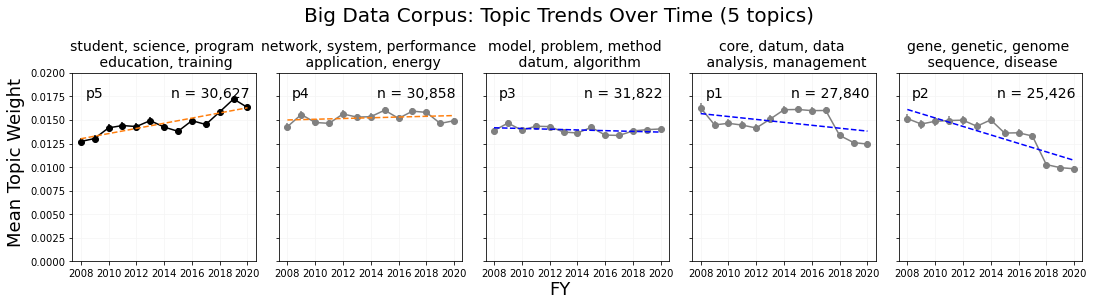

In [56]:
# set up grid
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(15,4))
plt.ylim(bottom = 0.00, top = 0.02) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in [0]): # upward trend in 2020, 20: [0,1,4,9,12]
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[j].set_title(new_leg[col_idx], fontsize = 14)
    
    # add topic number to each plot
    ax[j].text(0.12, 0.89, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[j].text(0.75, 0.89, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Big Data Corpus: Topic Trends Over Time (5 topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.75)

plt.savefig("Big_data_trends_5.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

#### Dominant Topic Funding Calculation

In [ ]:
doc_topic[0:10,:]

In [ ]:
type(doc_topic)

In [ ]:
dom_top_df = df.copy()

In [ ]:
dom_top_df['dom_top'] = np.argmax(doc_topic, axis=1)

In [ ]:
dom_top_df['dom_top'][0:20]

In [ ]:
dom_top_df.head()

In [ ]:
dollars_by_top_yr = dom_top_df.groupby(['dom_top', 'FY']).agg(COST = ('FY_TOTAL_COST_SUM', 'sum'),
                                        NUM_PROJECTS = ('PROJECT_ID', 'count'))
dollars_by_top_yr

In [ ]:
dollars_by_top_yr.index.get_level_values(0)

In [ ]:
dollars_by_top_yr.loc[0,'2008']

In [61]:
year = dollars_by_top_yr.loc[0]['COST'].index.values.astype('int')
year

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [77]:
dollars_by_top_yr.loc[1]['COST'].values

array([2.49584900e+07, 4.84257350e+07, 4.43161280e+07, 8.42726020e+07,
       2.70007410e+07, 1.94718570e+07, 1.44426010e+07, 2.19935570e+07,
       2.18596360e+07, 2.25130660e+07, 2.91272290e+07, 2.87742200e+07,
       1.71029352e+09])

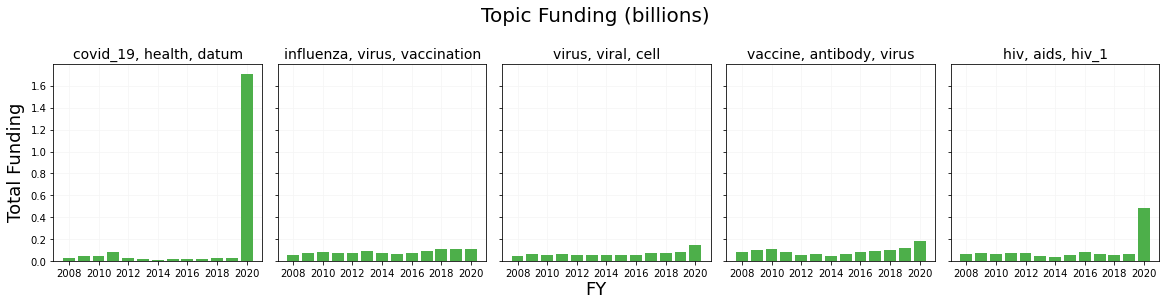

In [88]:
# set up grid
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    #i = count // 5
    j = count % 5
    
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[j].bar(year, cost, color = cb_pal['green']) 
    ax[j].grid(color = "whitesmoke")   
    ax[j].set_title(new_leg[topic], fontsize = 14)
    ax[j].set_axisbelow(True)
    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

#plt.savefig("./figures/pan_05topic_trends_alt.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends_alt.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

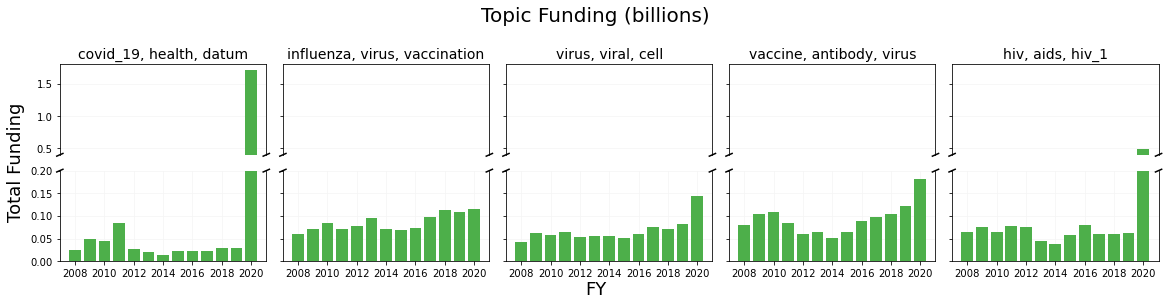

In [112]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = False, sharey = 'row', figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    # plot data
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[i+1,j].bar(year, cost, color = cb_pal['green']) 
    ax[i+1,j].grid(color = "whitesmoke")   
    ax[i+1,j].set_axisbelow(True)
    
    ax[i,j].bar(year, cost, color = cb_pal['green']) 
    ax[i,j].grid(color = "whitesmoke")   
    ax[i,j].set_title(new_leg[topic], fontsize = 14)
    ax[i,j].set_axisbelow(True)
    
    # broken axis
    ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].set_xticks([])
    ax[i+1,j].set_xticks(np.arange(2008,2021,2))
    ax[i+1,j].spines['top'].set_visible(False)
    ax[i+1,j].set_ylim([0,0.2])
    ax[i,j].set_ylim([0.4,1.8])
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[i,j].transAxes, color='k', clip_on=False)
    ax[i,j].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[i,j].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[i+1,j].transAxes)  # switch to the bottom axes
    ax[i+1,j].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[i+1,j].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig("./figures/OECD/pan_05topic_funding.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/OECD/pan_05topic_funding.pdf", dpi = 800, bbox_inches = "tight")
plt.show()